# GRU Simples - Morbidade Circulatória (Previsão da Próxima Semana)

Este notebook implementa um modelo GRU simples para prever a taxa de morbidade por doenças circulatórias para a próxima semana em uma cidade brasileira selecionada.

O fluxo de trabalho é totalmente modular, utilizando funções do diretório `src/` para cada etapa do processo:

1.  **Configuração:** Todos os parâmetros são definidos em uma única célula.
2.  **Carregamento e Preparação dos Dados:** Carrega os dados, filtra para a cidade de interesse e prepara as sequências para o modelo usando `prepare_data_for_model`.
3.  **Construção e Treinamento do Modelo:** Constrói um modelo GRU com `build_gru` e o treina com `train_model`.
4.  **Avaliação:** Avalia o modelo no conjunto de teste usando `evaluate_model`, que lida com a desnormalização para garantir que as métricas sejam calculadas na escala original.
5.  **Visualização e Salvamento:** Gera gráficos de previsão e salva as métricas e predições resultantes.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Adiciona o diretório raiz do projeto ao sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Adicionado {project_root} ao sys.path")

# Importa os módulos customizados
from src.preprocessing import load_city_data, prepare_data_for_model, filter_city, clean_timeseries
from src.models import build_gru
from src.train import train_model, evaluate_model, save_metrics, save_predictions
from src.utils import plot_forecast, plot_actual_vs_predicted_scatter, plot_training_history

# Define sementes aleatórias para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

print("Módulos importados e configuração inicial completa.")

Adicionado c:\Users\pedro\OneDrive - Unesp\Documentos\GitHub\cities-models\cities-models ao sys.path
Módulos importados e configuração inicial completa.


In [2]:
# =============================================================================
# Célula de Configuração
# =============================================================================
# --- Seleção dos Dados ---
CD_MUN_SELECTED = 3550308  # São Paulo
CITY_NAME = "Sao_Paulo"
TARGET_COLUMN = 'target'
FEATURE_COLUMNS = ['target']  # Apenas a variável alvo para o modelo GRU simples

# --- Divisão dos Dados ---
TEST_SIZE = 52  # Últimas 52 semanas para teste (1 ano)
VAL_SIZE = 52   # 52 semanas anteriores para validação

# --- Parâmetros do Modelo ---
SEQUENCE_LENGTH = 12
FORECAST_HORIZON = 1

# --- Parâmetros de Treinamento ---
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 15

# --- Arquitetura do Modelo ---
GRU_UNITS = 32
LOSS_FUNCTION = 'mae'

# --- Caminhos ---
DATA_PATH = '../data/df_base_morb_circ.csv'
RESULTS_DIR = os.path.join('results', 'morb_circ_gru_simple')
os.makedirs(RESULTS_DIR, exist_ok=True)

print("--- Configuração do Experimento ---")
print(f"Cidade: {CITY_NAME} ({CD_MUN_SELECTED})")
print(f"Variável Alvo: {TARGET_COLUMN}")
print(f"Tamanho da Sequência: {SEQUENCE_LENGTH}")
print(f"Horizonte de Previsão: {FORECAST_HORIZON}")
print(f"Tamanho do Teste: {TEST_SIZE}, Tamanho da Validação: {VAL_SIZE}")
print("-" * 20)

--- Configuração do Experimento ---
Cidade: Sao_Paulo (3550308)
Variável Alvo: target
Tamanho da Sequência: 12
Horizonte de Previsão: 1
Tamanho do Teste: 52, Tamanho da Validação: 52
--------------------


In [3]:
# =============================================================================
# Carregar Dados
# =============================================================================
df_full = load_city_data(DATA_PATH)
print(f"Dataset completo carregado: {df_full.shape}")
display(df_full.head())

Dataset completo carregado: (6344064, 11)


,CD_MUN,target,week,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
0,1100015,0.199872,1999-01-01,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
1,1100015,1.304184,1999-01-08,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
2,1100015,2.495194,1999-01-15,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
3,1100015,3.538533,1999-01-22,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39
4,1100015,11.927224,1999-01-29,3469.14,3.541043,0.000611,550.985905,92.946598,6.657747,-12.883213,-62.39


In [4]:
# =============================================================================
# Filtrar e Limpar Dados para a Cidade Selecionada
# =============================================================================
df_city = filter_city(df_full, cd_mun=CD_MUN_SELECTED)

# --- Conversão de Data e Indexação ---
df_city['week'] = pd.to_datetime(df_city['week'])
df_city = df_city.set_index('week').sort_index()

df_city = clean_timeseries(df_city, target_column=TARGET_COLUMN)
print(f"Dados para {CITY_NAME}: {df_city.shape}")
display(df_city.head())

Dados para Sao_Paulo: (1152, 10)


,CD_MUN,target,PIB,DENS,URB,CO2,CH4,N2O,LAT,LON
week,,,,,,,,,,
1999-01-01,3550308,7.321651,14743.57,6553.033617,0.53651,912649.390274,10400.103354,52.619816,-23.700046,-46.711
1999-01-08,3550308,7.599934,14743.57,6553.033617,0.53651,912649.390274,10400.103354,52.619816,-23.700046,-46.711
1999-01-15,3550308,7.851185,14743.57,6553.033617,0.53651,912649.390274,10400.103354,52.619816,-23.700046,-46.711
1999-01-22,3550308,8.000878,14743.57,6553.033617,0.53651,912649.390274,10400.103354,52.619816,-23.700046,-46.711
1999-01-29,3550308,8.236059,14743.57,6553.033617,0.53651,912649.390274,10400.103354,52.619816,-23.700046,-46.711


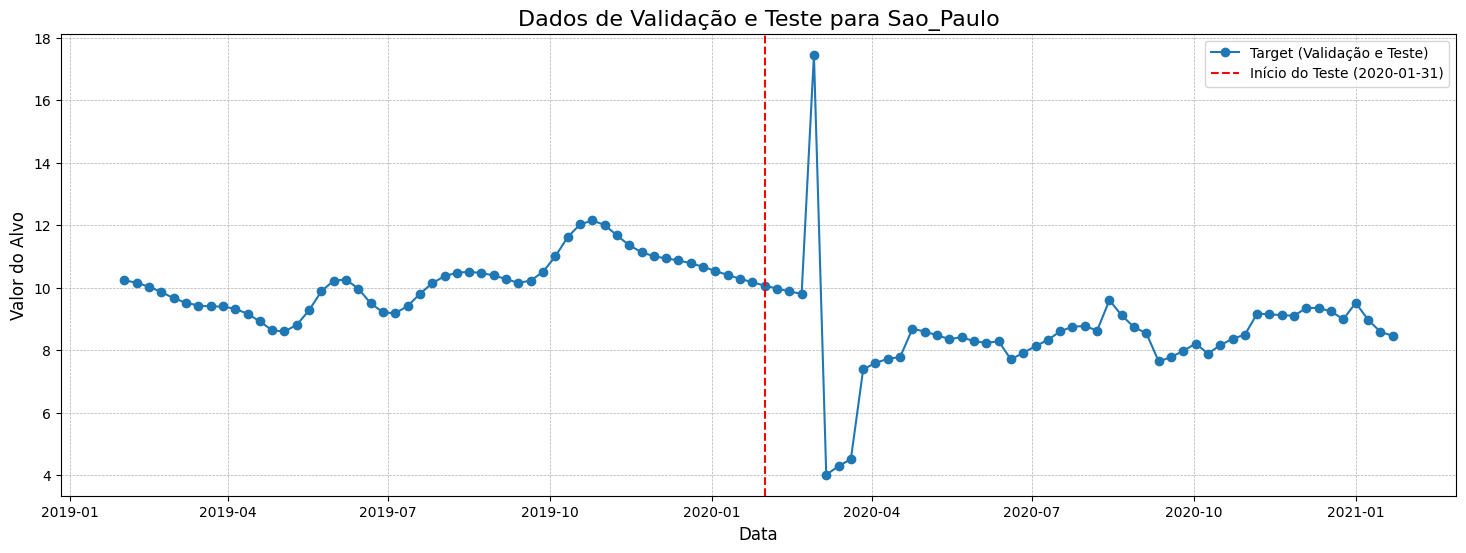

In [13]:
# =============================================================================
# Plotar os Dados de Validação e Teste
# =============================================================================
import matplotlib.pyplot as plt

# Seleciona os dados de validação e teste
val_test_df = df_city.iloc[-(VAL_SIZE + TEST_SIZE):]

fig, ax = plt.subplots(figsize=(18, 6))

# Plotando a série temporal
ax.plot(val_test_df.index, val_test_df[TARGET_COLUMN], marker='o', linestyle='-', label='Target (Validação e Teste)')

# Adicionar uma linha para a data de início do teste para referência
test_start_date = df_city.index[-TEST_SIZE]
ax.axvline(test_start_date, color='red', linestyle='--', label=f'Início do Teste ({test_start_date.date()})')

ax.set_title(f'Dados de Validação e Teste para {CITY_NAME}', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Valor do Alvo', fontsize=12)
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

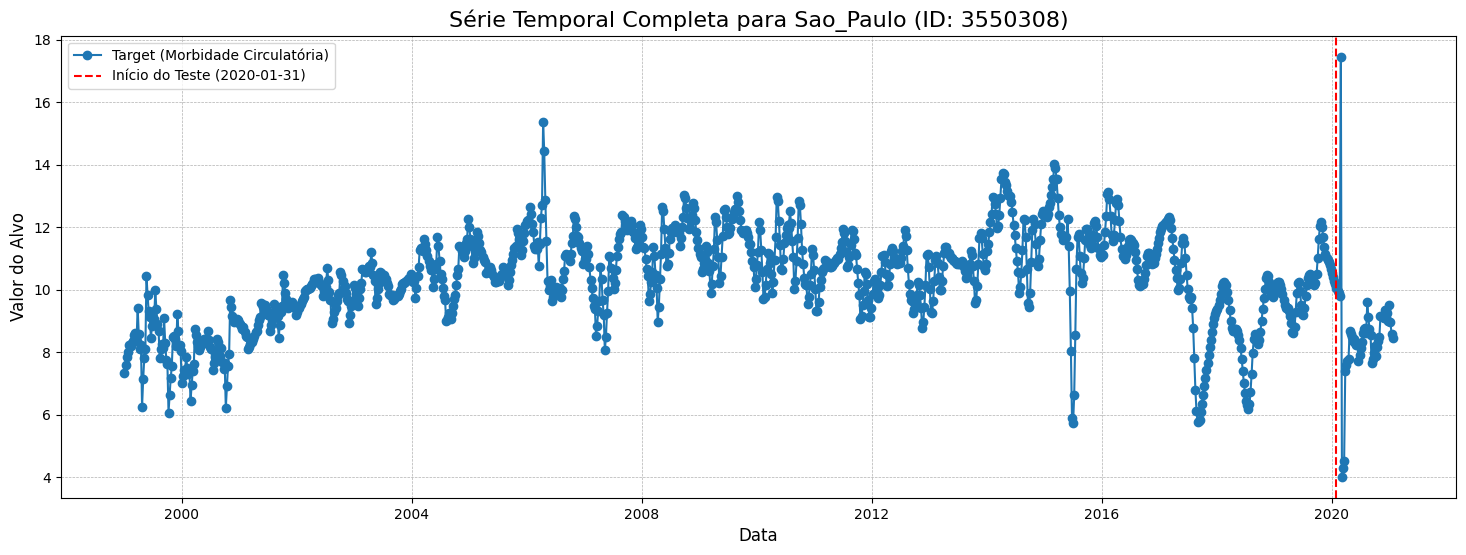

In [10]:
# =============================================================================
# Sanity Check: Plotar a Série Temporal Completa
# =============================================================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18, 6))

# Plotando a série temporal completa para a cidade selecionada
ax.plot(df_city.index, df_city[TARGET_COLUMN], marker='o', linestyle='-', label='Target (Morbidade Circulatória)')

ax.set_title(f'Série Temporal Completa para {CITY_NAME} (ID: {CD_MUN_SELECTED})', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Valor do Alvo', fontsize=12)
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adicionar uma linha para a data de início do teste para referência
test_start_date = df_city.index[-TEST_SIZE]
ax.axvline(test_start_date, color='red', linestyle='--', label=f'Início do Teste ({test_start_date.date()})')
ax.legend()

plt.show()

In [5]:
# =============================================================================
# Preparar Dados para o Modelo
# =============================================================================
data_dict = prepare_data_for_model(
    df=df_city,
    target_column=TARGET_COLUMN,
    feature_columns=FEATURE_COLUMNS.copy(),  # <<< Passa uma cópia para evitar modificação
    sequence_length=SEQUENCE_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
    test_size=TEST_SIZE,
    val_size=VAL_SIZE,
)

# Desempacota o dicionário de dados
X_train, y_train = data_dict['X_train'], data_dict['y_train']
X_val, y_val = data_dict['X_val'], data_dict['y_val']
X_test, y_test = data_dict['X_test'], data_dict['y_test']
scaler = data_dict['scaler']
original_train_df = data_dict['original_train_df']
original_val_df = data_dict['original_val_df']
original_test_df = data_dict['original_test_df']

print("--- Dimensões dos Dados ---")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

--- Dimensões dos Dados ---
X_train: (1036, 12, 1), y_train: (1036,)
X_val:   (40, 12, 1), y_val:   (40,)
X_test:  (40, 12, 1), y_test:  (40,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5726 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5726 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3558 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3558 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3222 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3222 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3004 - val_loss: 0.2498 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3004 - val_loss: 0.2498 - learning_rate: 0.0010
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2807 - val_loss: 0.2250 - learning_rate: 0.0010
Epoch 6/100
33/33

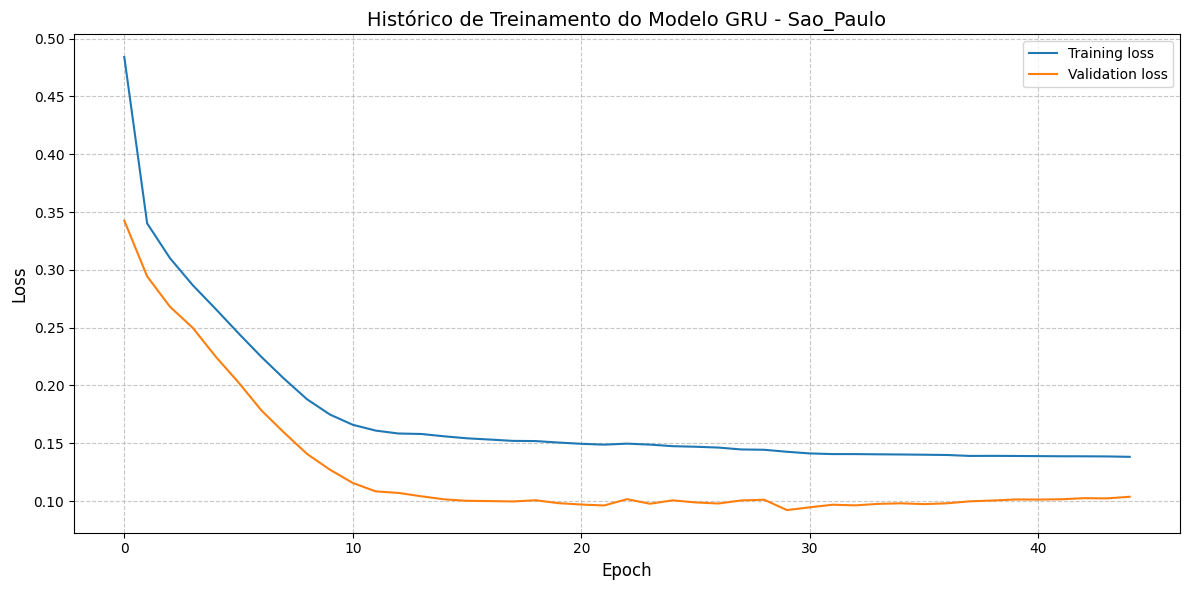

In [6]:
# =============================================================================
# Construir e Treinar o Modelo GRU
# =============================================================================
input_shape = X_train.shape[1:]
model = build_gru(
    input_shape=input_shape,
    units=GRU_UNITS,
    loss=LOSS_FUNCTION
)
model.summary()

history = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    verbose=1
)

# Plota o histórico de treinamento
fig_history = plot_training_history(history, title=f'Histórico de Treinamento do Modelo GRU - {CITY_NAME}')
plt.savefig(os.path.join(RESULTS_DIR, f'{CITY_NAME}_training_history.png'), dpi=300)
plt.show()

In [7]:
# =============================================================================
# Avaliar o Modelo no Conjunto de Teste
# =============================================================================
# 1. Gerar previsões normalizadas
y_pred_normalized = model.predict(X_test)

# 2. Avaliar usando a função que desnormaliza e calcula as métricas
metrics = evaluate_model(
    y_true=y_test,
    y_pred=y_pred_normalized,
    scaler=scaler,
    target_idx=FEATURE_COLUMNS.index(TARGET_COLUMN)
)

# Extrai os valores desnormalizados para plotagem
y_true_denorm = metrics['y_true_denorm']
y_pred_denorm = metrics['y_pred_denorm']

# Imprime as métricas
print(f"--- Métricas do Conjunto de Teste para {CITY_NAME} ---")
print(f"MAE:  {metrics['mae']:.4f}")
print(f"RMSE: {metrics['rmse']:.4f}")
print(f"R²:   {metrics['r2']:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
--- Métricas do Conjunto de Teste para Sao_Paulo ---
MAE:  0.3125
RMSE: 0.4295
R²:   0.2685
--- Métricas do Conjunto de Teste para Sao_Paulo ---
MAE:  0.3125
RMSE: 0.4295
R²:   0.2685


In [8]:
# =============================================================================
# Sanity Check de Escala e Datas
# =============================================================================
print("--- Verificação de Sanidade ---")

# 1. Checar as datas do conjunto de teste original
# As datas devem ser do tipo datetime e corresponder ao período de teste.
test_dates = original_test_df.index[-len(y_true_denorm):]
print(f"\n1. Verificação das Datas:")
print(f"   - Tipo do índice de datas: {type(test_dates)}")
print(f"   - Data de início do teste: {test_dates.min()}")
print(f"   - Data de fim do teste: {test_dates.max()}")
print(f"   - Total de datas: {len(test_dates)}")

# 2. Comparar a escala dos dados originais, normalizados e desnormalizados
original_target_test = original_test_df[TARGET_COLUMN][-len(y_true_denorm):]

print(f"\n2. Verificação da Escala dos Dados:")
print("   --- Dados Originais (Ground Truth) ---")
print(f"   - Mínimo: {original_target_test.min():.4f}")
print(f"   - Máximo: {original_target_test.max():.4f}")
print(f"   - Média:  {original_target_test.mean():.4f}")

print("\n   --- Dados de Teste (Normalizados) ---")
print(f"   - y_test (real): Min={y_test.min():.4f}, Max={y_test.max():.4f}, Média={y_test.mean():.4f}")
print(f"   - y_pred (previsto): Min={y_pred_normalized.min():.4f}, Max={y_pred_normalized.max():.4f}, Média={y_pred_normalized.mean():.4f}")

print("\n   --- Dados Desnormalizados (Resultado Final) ---")
print(f"   - y_true_denorm: Min={y_true_denorm.min():.4f}, Max={y_true_denorm.max():.4f}, Média={y_true_denorm.mean():.4f}")
print(f"   - y_pred_denorm: Min={y_pred_denorm.min():.4f}, Max={y_pred_denorm.max():.4f}, Média={y_pred_denorm.mean():.4f}")

# 3. Inspecionar o scaler
# O scaler deve ter sido treinado nos dados de treino. A média e a escala para a variável alvo (índice 0)
# devem corresponder à distribuição dos dados de treino.
target_scaler_mean = scaler.mean_[FEATURE_COLUMNS.index(TARGET_COLUMN)]
target_scaler_scale = scaler.scale_[FEATURE_COLUMNS.index(TARGET_COLUMN)]
print(f"\n3. Verificação do Scaler (para a variável '{TARGET_COLUMN}'):")
print(f"   - Média do Scaler: {target_scaler_mean:.4f}")
print(f"   - Escala (Desvio Padrão) do Scaler: {target_scaler_scale:.4f}")

print("\n--- Fim da Verificação ---")
# Se a escala dos 'Dados Desnormalizados' não corresponder à dos 'Dados Originais',
# há um problema na função `evaluate_model` ou na forma como o scaler está sendo usado.
# Se as datas estiverem incorretas, o problema está na preparação do dataframe antes do passo `prepare_data_for_model`.

--- Verificação de Sanidade ---

1. Verificação das Datas:
   - Tipo do índice de datas: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   - Data de início do teste: 2020-04-24 00:00:00
   - Data de fim do teste: 2021-01-22 00:00:00
   - Total de datas: 40

2. Verificação da Escala dos Dados:
   --- Dados Originais (Ground Truth) ---
   - Mínimo: 7.6438
   - Máximo: 9.6021
   - Média:  8.5956

   --- Dados de Teste (Normalizados) ---
   - y_test (real): Min=-1.8856, Max=-0.5510, Média=-1.2369
   - y_pred (previsto): Min=-2.0748, Max=-0.5023, Média=-1.2009

   --- Dados Desnormalizados (Resultado Final) ---
   - y_true_denorm: Min=7.6438, Max=9.6021, Média=8.5956
   - y_pred_denorm: Min=7.3661, Max=9.6736, Média=8.6484

3. Verificação do Scaler (para a variável 'target'):
   - Média do Scaler: 10.4106
   - Escala (Desvio Padrão) do Scaler: 1.4674

--- Fim da Verificação ---


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


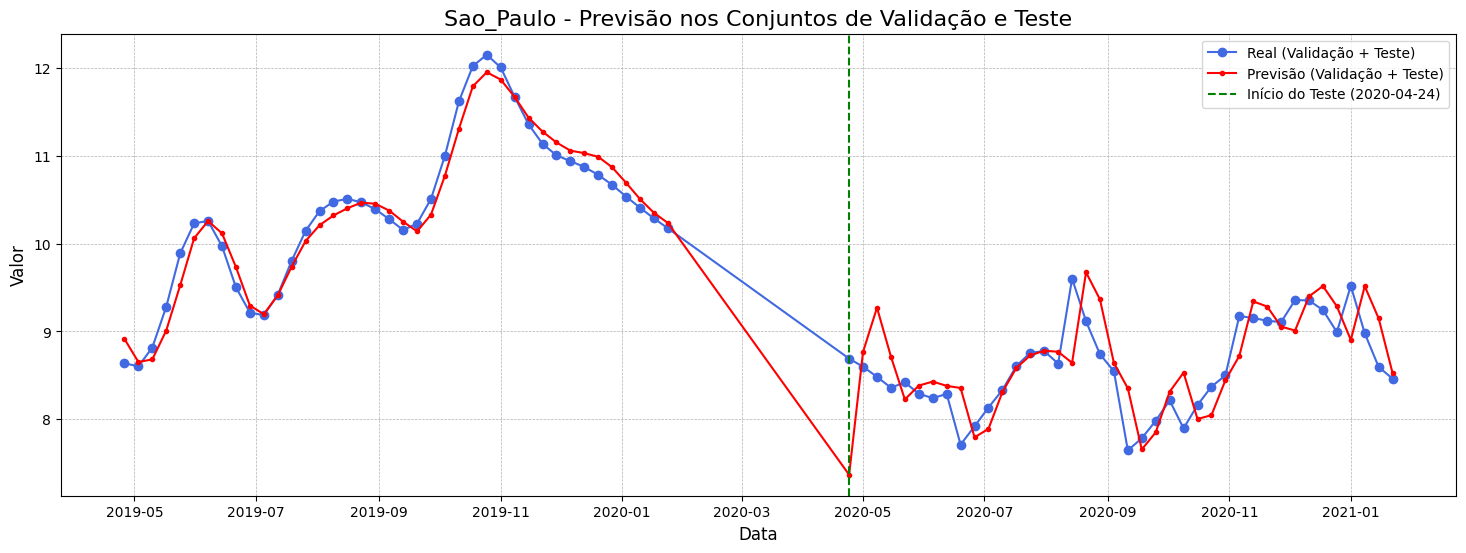

C:\Users\pedro\AppData\Local\Temp\ipykernel_26360\992479461.py:55: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_scatter.show()


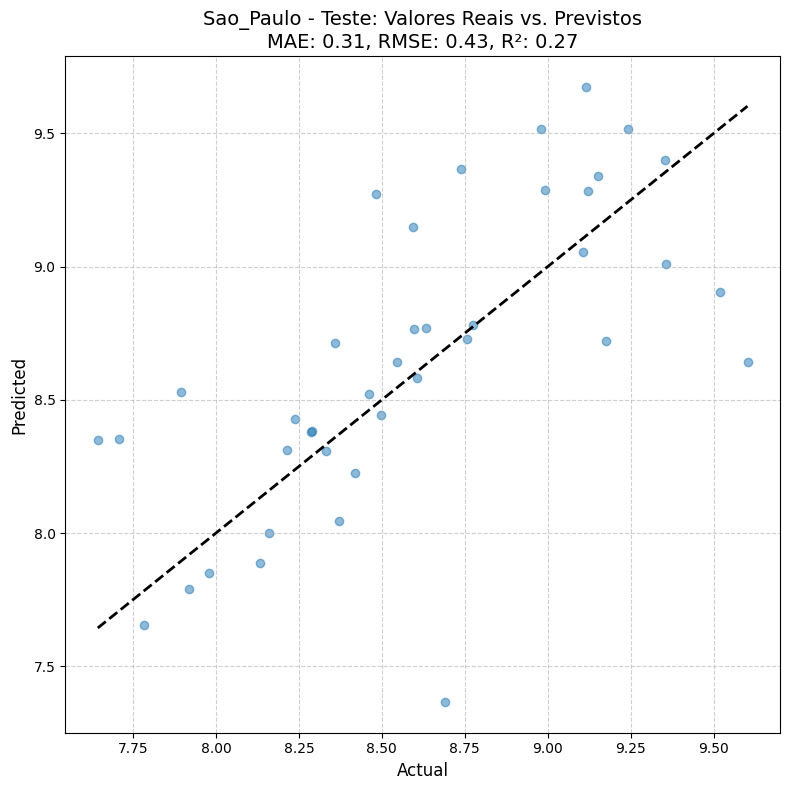

In [14]:
# =============================================================================
# Visualizar Previsões (Validação + Teste)
# =============================================================================
# 1. Gerar previsões para o conjunto de validação para plotagem
y_val_pred_normalized = model.predict(X_val)

# 2. Desnormalizar os dados de validação
val_metrics = evaluate_model(
    y_true=y_val,
    y_pred=y_val_pred_normalized,
    scaler=scaler,
    target_idx=FEATURE_COLUMNS.index(TARGET_COLUMN)
)
y_val_true_denorm = val_metrics['y_true_denorm']
y_val_pred_denorm = val_metrics['y_pred_denorm']

# 3. Combinar dados de validação e teste para um único plot
# (y_true_denorm e y_pred_denorm do teste já foram calculados na célula anterior)
combined_true = np.concatenate([y_val_true_denorm, y_true_denorm])
combined_pred = np.concatenate([y_val_pred_denorm, y_pred_denorm])

# 4. Combinar as datas correspondentes
val_dates = original_val_df.index[-len(y_val_true_denorm):]
test_dates = original_test_df.index[-len(y_true_denorm):]
combined_dates = val_dates.union(test_dates)

# --- Gráfico Combinado (Validação + Teste) ---
fig_combined, ax = plt.subplots(figsize=(18, 6))

# Plotar valores reais e previsões
ax.plot(combined_dates, combined_true, 'o-', color='royalblue', label='Real (Validação + Teste)')
ax.plot(combined_dates, combined_pred, '.-', color='red', label='Previsão (Validação + Teste)')

# Marcar o início do conjunto de teste
test_start_date = test_dates[0]
ax.axvline(x=test_start_date, color='green', linestyle='--', label=f'Início do Teste ({test_start_date.date()})')

ax.set_title(f'{CITY_NAME} - Previsão nos Conjuntos de Validação e Teste', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
fig_combined.savefig(os.path.join(RESULTS_DIR, f'{CITY_NAME}_combined_forecast.png'), dpi=300)
plt.show()


# --- Gráfico de Dispersão (Apenas Teste) ---
fig_scatter = plot_actual_vs_predicted_scatter(
    y_true=y_true_denorm,
    y_pred=y_pred_denorm,
    title=f'{CITY_NAME} - Teste: Valores Reais vs. Previstos',
    metrics=metrics
)
fig_scatter.savefig(os.path.join(RESULTS_DIR, f'{CITY_NAME}_scatter_plot.png'), dpi=300)
fig_scatter.show()

In [ ]:
# =============================================================================
# Salvar Resultados
# =============================================================================
# Salvar predições
preds_file = save_predictions(
    y_true=y_true_denorm,
    y_pred=y_pred_denorm,
    dates=test_dates,
    city_name=CITY_NAME,
    model_name='gru_simple',
    output_dir=RESULTS_DIR
)
print(f"Predições salvas em: {preds_file}")

# Salvar métricas
params_to_save = {
    'city_name': CITY_NAME,
    'cd_mun': CD_MUN_SELECTED,
    'sequence_length': SEQUENCE_LENGTH,
    'forecast_horizon': FORECAST_HORIZON,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'gru_units': GRU_UNITS
}
metrics_to_save = {k: v for k, v in metrics.items() if k in ['mae', 'rmse', 'r2']}

metrics_file = save_metrics(
    metrics=metrics_to_save,
    city_name=CITY_NAME,
    model_name='gru_simple',
    output_dir=RESULTS_DIR,
    params=params_to_save
)
print(f"Métricas salvas em: {metrics_file}")

## Conclusão

Este notebook demonstrou um fluxo de trabalho limpo e modular para treinar, avaliar e visualizar um modelo GRU simples para previsão de séries temporais.

- **Código Modular:** Toda a lógica de pré-processamento, modelagem, treinamento e avaliação foi importada do diretório `src/`, mantendo o notebook limpo e focado na orquestração do fluxo de trabalho.
- **Avaliação Correta:** A função `evaluate_model` garantiu que a desnormalização fosse aplicada antes do cálculo das métricas, fornecendo uma avaliação precisa do desempenho do modelo na escala original dos dados.
- **Reprodutibilidade:** O uso de uma célula de configuração centralizada e sementes aleatórias facilita a reprodução e a experimentação.
- **Visualização Clara:** As visualizações mostram o desempenho do modelo no conjunto de teste, fornecendo insights sobre sua capacidade de generalização.

O desempenho deste modelo GRU simples serve como uma base sólida para a comparação com modelos mais complexos.